In [7]:
%matplotlib inline

import os
import copy
import random
import colorsys
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageChops
from scipy import misc
from scipy import ndimage

matplotlib.rcParams['figure.figsize'] = (20, 20)

# Read in sample images

In [19]:
source = misc.imread(os.path.join('data', 'uv_tests', 'Image0001.png'))
uv = misc.imread(os.path.join('data', 'uv_tests', 'uv0001.png'))
texture = misc.imread(os.path.join('data', 'uv_tests', 'textures', 'blue.png'))

# Plot the Images

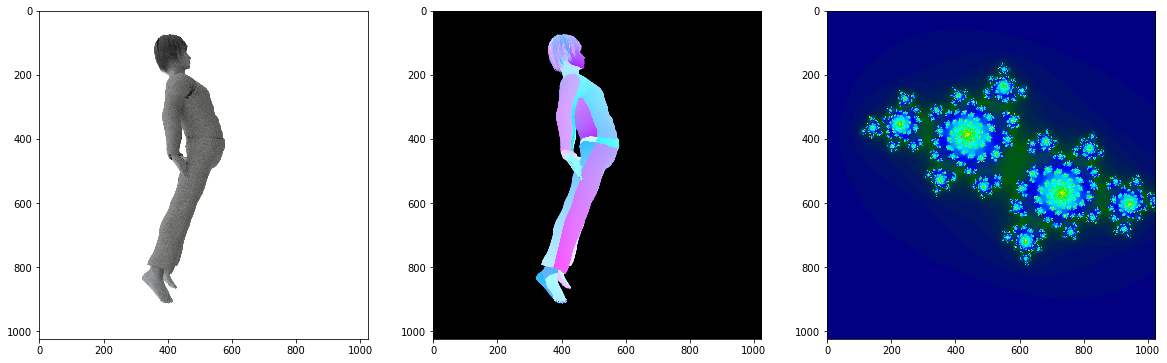

In [7]:
fig = plt.figure()

fig.add_subplot(1, 3, 1)
plt.imshow(source)


fig.add_subplot(1, 3, 2)
plt.imshow(uv)

fig.add_subplot(1, 3, 3)
plt.imshow(texture)

plt.show()

## Try upsampling the texture

In [25]:
new_texture = misc.imresize(texture, 5.0, interp='bicubic')


/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [26]:
uv_coords = uv[:, :, :2].transpose(2, 0, 1) * (new_texture.shape[0] / (30*255.0)) + (new_texture.shape[0] * 0.40)
uv_coords.shape

(2, 1024, 1024)

In [22]:
import scipy.stats
scipy.stats.describe(uv_coords[0,:,:].reshape(1024*1024))

DescribeResult(nobs=1048576, minmax=(2048.0, 2217.3281045751633), mean=2057.9590322457097, variance=1138.3274636767387, skewness=3.288822717540586, kurtosis=9.355758173243586)

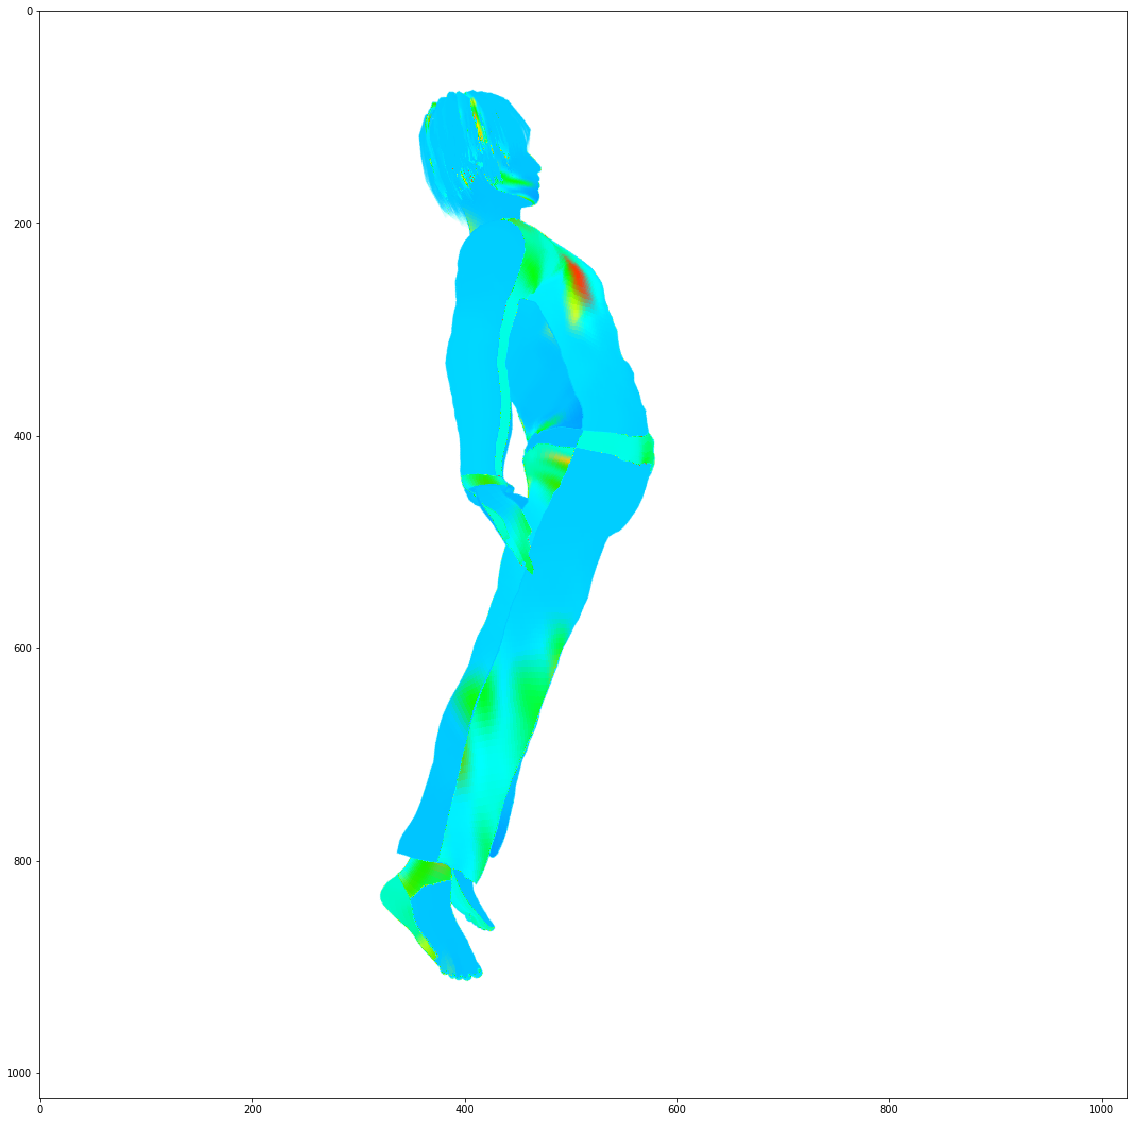

In [23]:
test_r = ndimage.map_coordinates(new_texture[:,:,0], uv_coords, order=2, prefilter=True, mode='wrap')
test_g = ndimage.map_coordinates(new_texture[:,:,1], uv_coords, order=2, prefilter=True, mode='wrap')
test_b = ndimage.map_coordinates(new_texture[:,:,2], uv_coords, order=2, prefilter=True, mode='wrap')
test_a = source[:, :, 3]

test = np.stack([test_r, test_g, test_b, test_a], axis=2)
plt.imshow(test)

## Try standard image

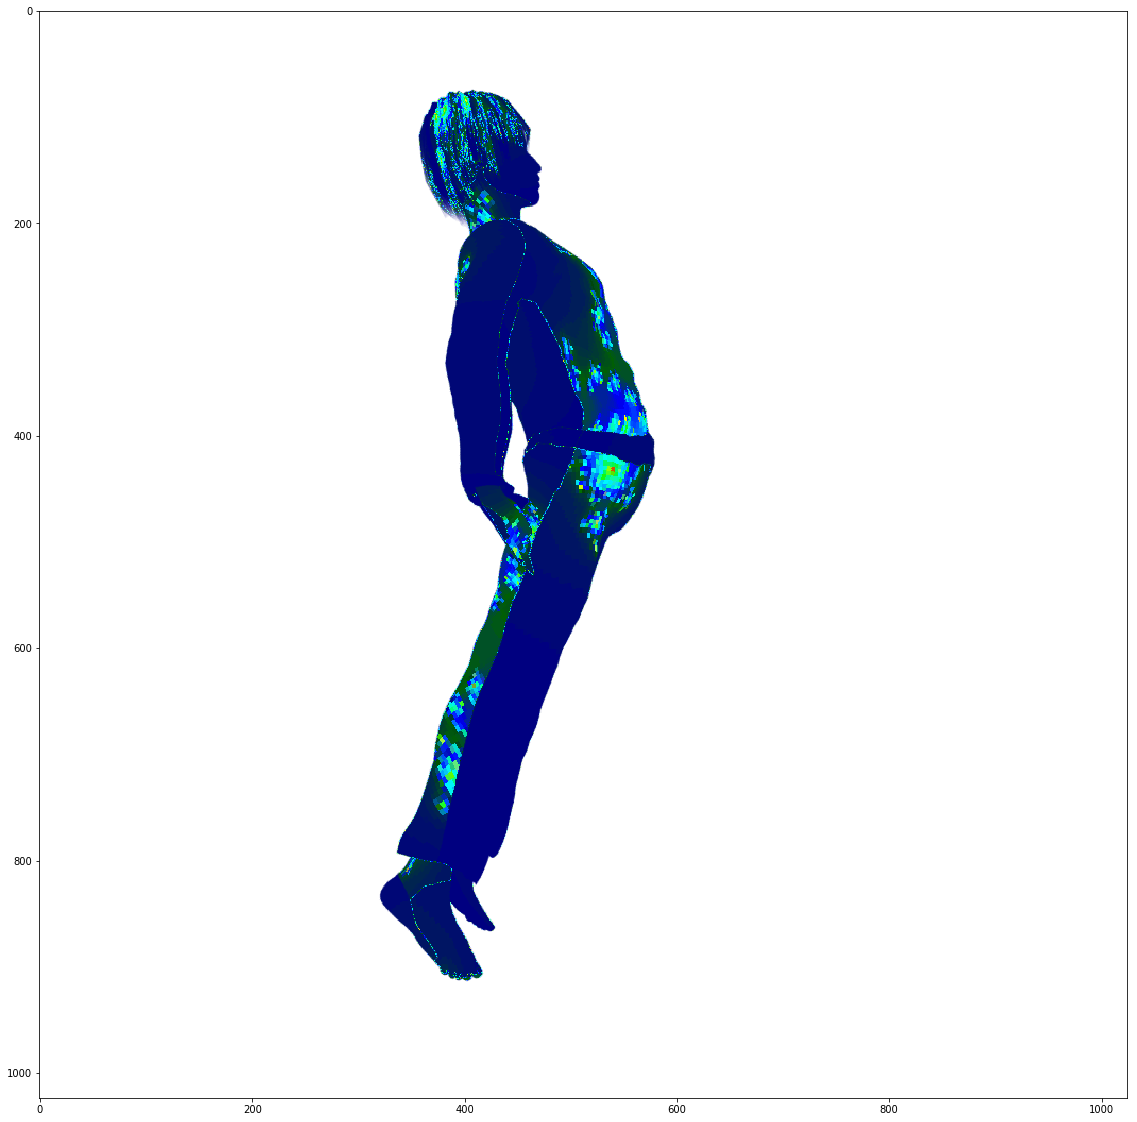

In [24]:
uv_coords = uv[:, :, :2].transpose(2, 0, 1) * (1024 / 255)
uv_coords.shape

test_r = ndimage.map_coordinates(texture[:,:,0], uv_coords, order=2, prefilter=True, mode='wrap')
test_g = ndimage.map_coordinates(texture[:,:,1], uv_coords, order=2, prefilter=True, mode='wrap')
test_b = ndimage.map_coordinates(texture[:,:,2], uv_coords, order=2, prefilter=True, mode='wrap')
test_a = source[:, :, 3]

test = np.stack([test_r, test_g, test_b, test_a], axis=2)
plt.imshow(test)

# Use EXR (32 bit) instead of PNG (8 bit) UV map

In [27]:
import OpenEXR
import Imath

exr_uv = OpenEXR.InputFile(os.path.join('data', 'uv_tests', 'uv0001_noaa.exr'))
pixel_type = Imath.PixelType(Imath.PixelType.FLOAT)
dw = exr_uv.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y +1)
uv_r = exr_uv.channel('R', pixel_type)
uv_r = Image.frombytes('F', size, uv_r)

uv_g = exr_uv.channel('G', pixel_type)
uv_g = Image.frombytes('F', size, uv_g)

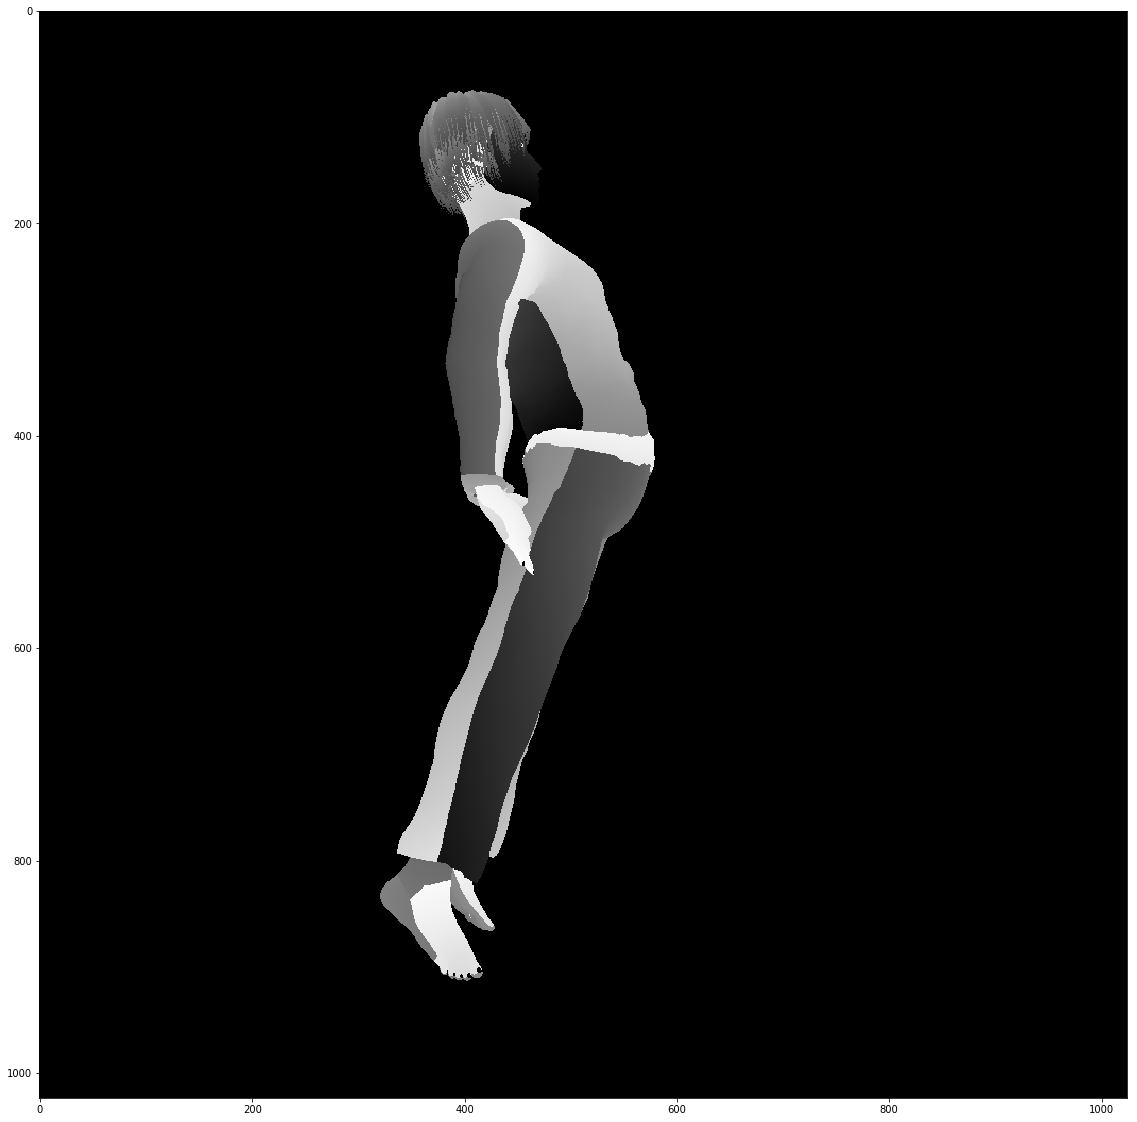

In [28]:
test = np.asarray(uv_g) * 255
test2 = Image.fromarray(test)
plt.imshow(test2)

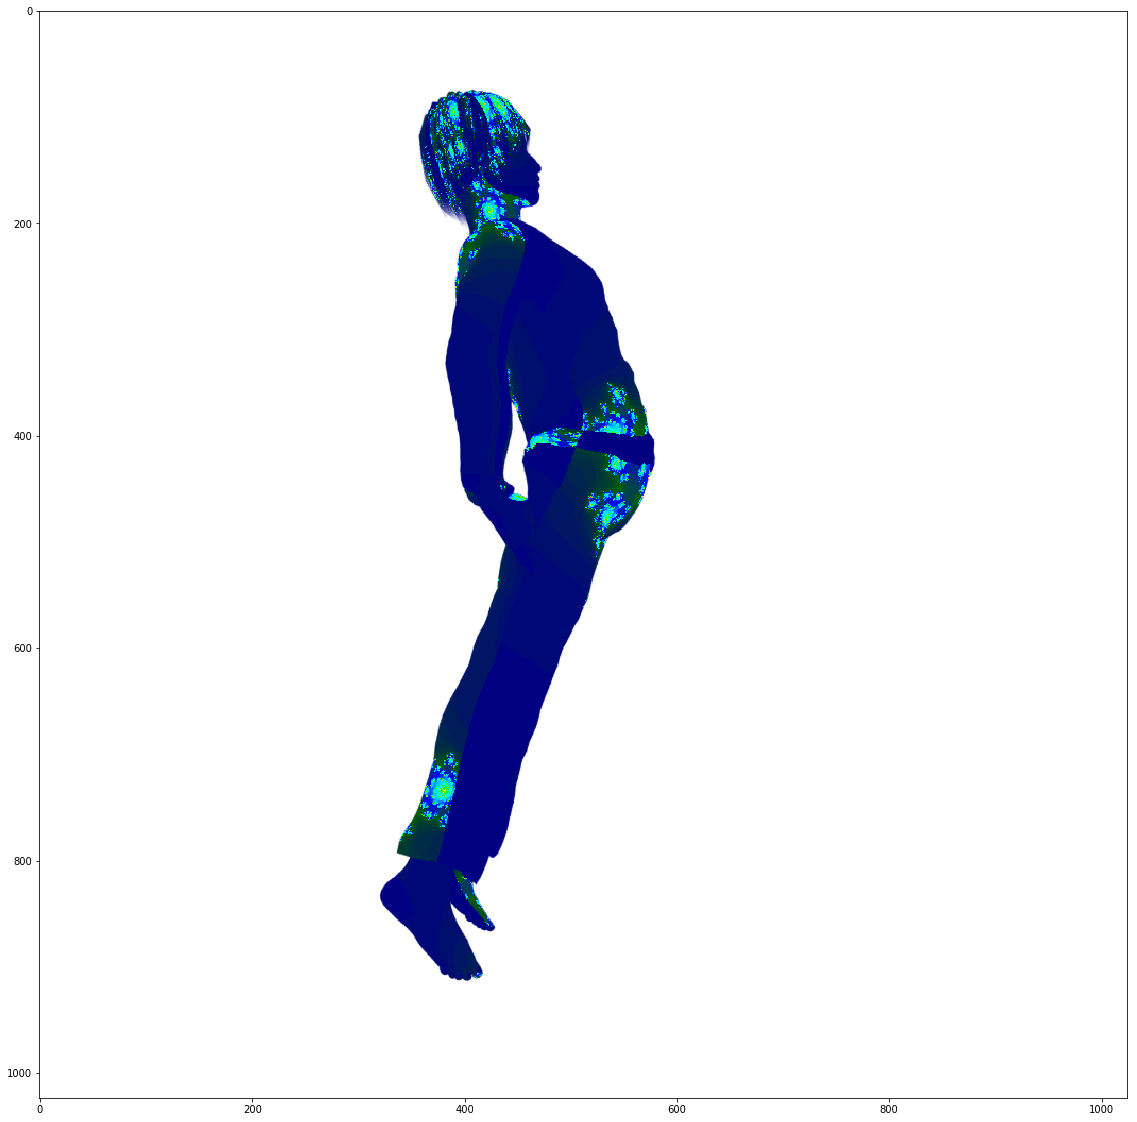

In [9]:
uv_factor = 1024
u = np.asarray(uv_r) * uv_factor
v = np.asarray(uv_g) * uv_factor

uv = np.stack([u, v], axis=2)
uv = uv.transpose(2, 0, 1)

mapped_r = ndimage.map_coordinates(texture[:, :, 0], uv, prefilter=False, order=0)
mapped_g = ndimage.map_coordinates(texture[:, :, 1], uv, prefilter=False, order=0)
mapped_b = ndimage.map_coordinates(texture[:, :, 2], uv, prefilter=False, order=0)
mapped_a = source[:, :, 3]

mapped_1 = np.stack([mapped_r, mapped_g, mapped_b, mapped_a], axis=2)

plt.imshow(mapped_1)
plt.show()

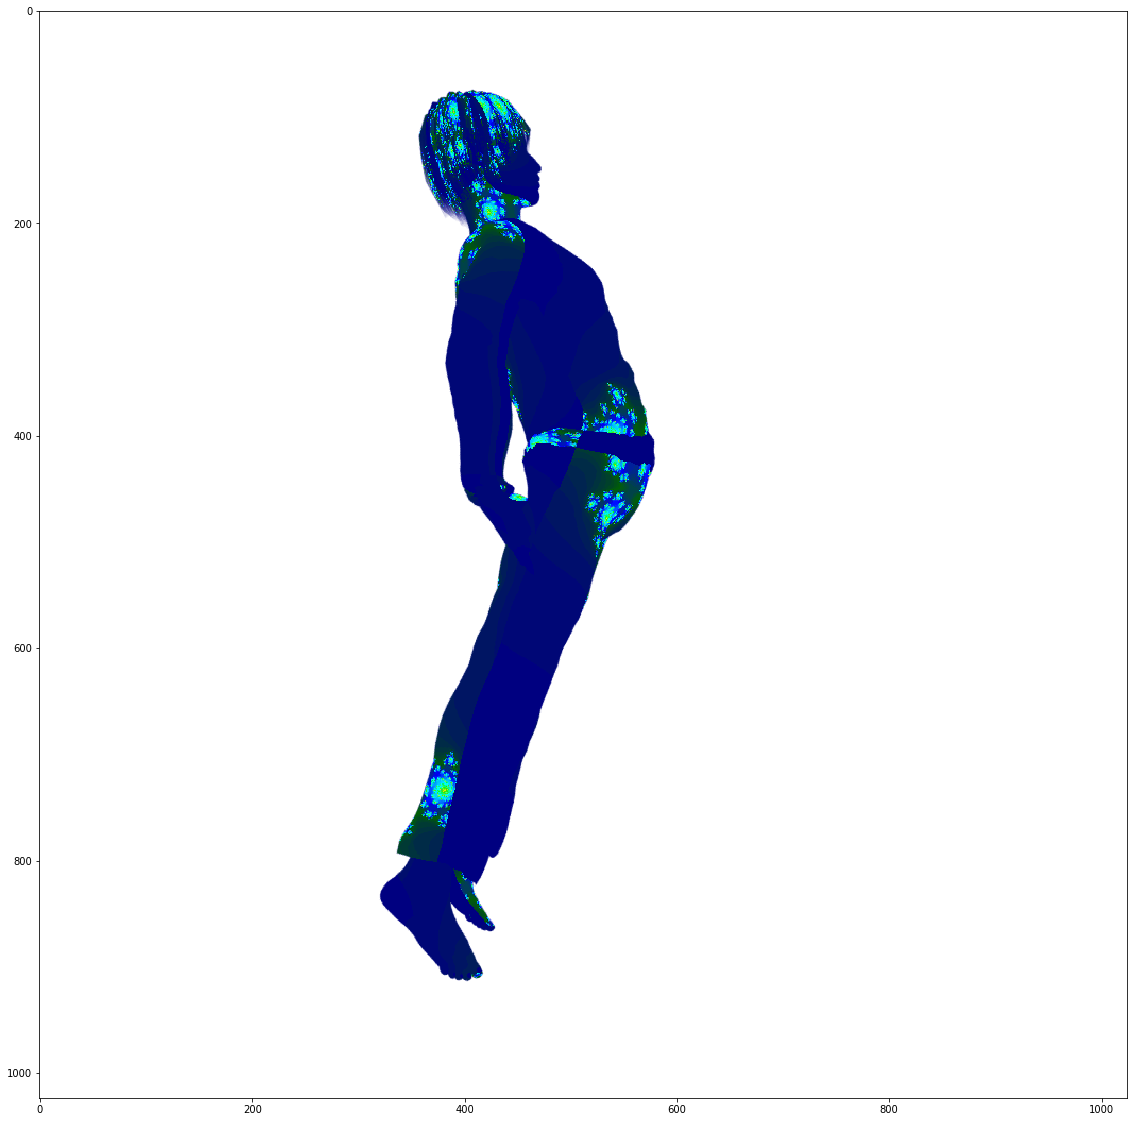

In [10]:
uv_factor = 1025
u = np.asarray(uv_r) * uv_factor
v = np.asarray(uv_g) * uv_factor

uv = np.stack([u, v], axis=2)
uv = uv.transpose(2, 0, 1)

mapped_r = ndimage.map_coordinates(texture[:, :, 0], uv)
mapped_g = ndimage.map_coordinates(texture[:, :, 1], uv)
mapped_b = ndimage.map_coordinates(texture[:, :, 2], uv)
mapped_a = source[:, :, 3]

mapped_2 = np.stack([mapped_r, mapped_g, mapped_b, mapped_a], axis=2)

plt.imshow(mapped_2)
plt.show()

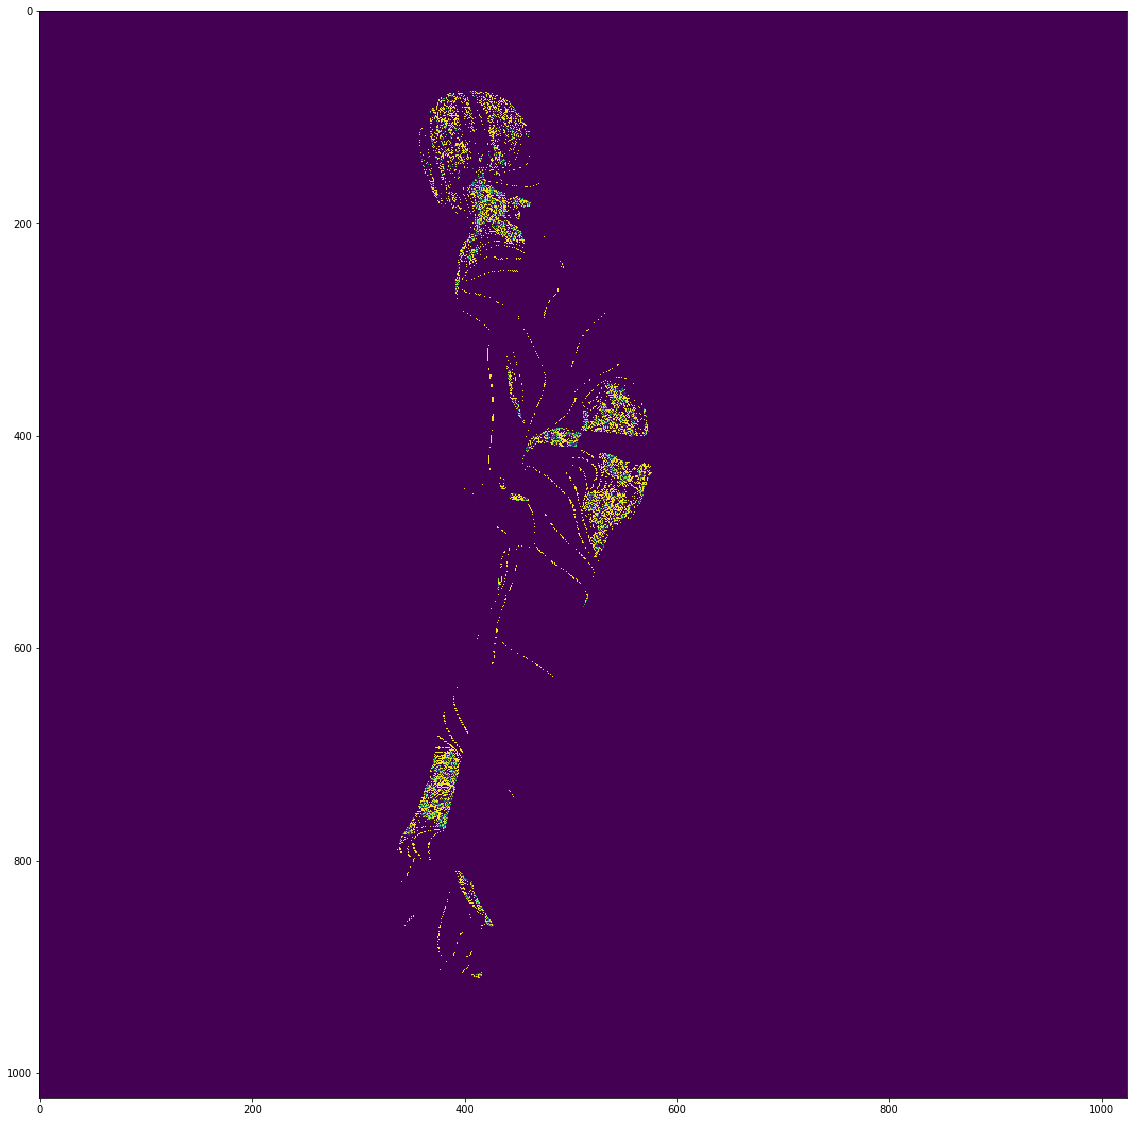

In [11]:
diffs = np.abs(mapped_1 - mapped_2)
diffs = diffs/np.max(diffs)

plt.imshow(diffs[:, :, 1])
plt.show()

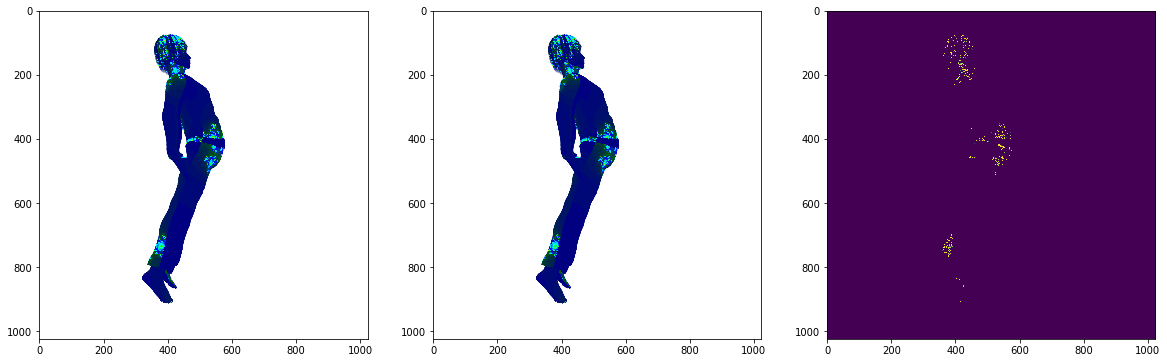

In [12]:
fig = plt.figure()

fig.add_subplot(1, 3, 1)
plt.imshow(mapped_1)

fig.add_subplot(1, 3, 2)
plt.imshow(mapped_2)

fig.add_subplot(1, 3, 3)
plt.imshow(diffs[:, :, 0])

plt.show()